In [1]:
# Feel free to import any other functions you might need!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner

# Exploring WASP-12 b's Orbital Decay

Hello! In this assignment, we're going to be exploring the orbital decay of WASP-12 b.

Without getting too into the weeds here, hot Jupiters are hot, Jupiter-sized planets very close to their host stars. Current theories predict that the orbits of these hot Jupiters should be slowly decaying over time thanks to dynamical interactions causing angular momentum transfer from the planet to the star, but detecting this is very difficult!

In this assignment, we are going to try to replicate (some of) the results of [Hagey et al. (2022)](https://iopscience.iop.org/article/10.3847/1538-3881/ac959a/pdf). Let's go a little into detail about those results here.

In the paper, they take a look at three different models of transit times (meaning the *center time of transit*, the middle of the dip of the light in a transit.) The three models are described in §4.1 of the paper, but they are briefly described as follows:

• **Model 1** claims that no such orbital decay exists, and that transits follow a perfectly linear pattern. Specifically, given a period $P$, an *epoch* (essentially the transit number) $E$, and a *reference epoch* (the time of transit 0) $t_0$, the center time of transit is given by

\begin{equation}
t_{tra} = t_0 + PE
\end{equation}

• **Model 2** claims that the orbital period is steadily decreasing at a constant rate with epoch, thanks to the orbital decay we mentioned earlier. Given a rate of change of period with epoch $\frac{dP}{dE} < 0$, then, the center time of transit is given by

\begin{equation}
t_{tra} = t_0 + PE + \frac{1}{2}\frac{dP}{dE} E^2
\end{equation}

If this model fits our data the best, then it suggests that our planet's orbit truly is decaying!

• **Model 3** claims that a different process, *apsidal precession* (the orbit slowly rotating over time) is responsible for this change, rather than orbital decay being responsible. Given an eccentricity $e$, an arugment of pericenter at epoch $\omega_0$, and its rate of change $\frac{d\omega}{dE}$, the center time of transit is given by

\begin{align}
t_{tra} & = t_0 + PE - \frac{eP_a}{\pi} \cos \omega(E) \\
\omega(E) & = \omega_0 + \frac{d\omega}{dE}E \\
P_a & = \frac{P}{1 - \frac{d\omega / dE}{2\pi}}
\end{align}

This paper compares these three models for many different targets (ultimately concluding that some, but not all, of them show evidence of orbital decay), but we will focus on just WASP-12 b for now.

Before we code these models up, let us take a look at what our data looks like:

In [2]:
data = pd.read_csv("WASP-12_ETD_clean.txt", sep = "\t", names = ["Index", "Epoch", "Transit Time", "Error", "Data Quality", "Observer"])

linmod = (2454508.978941705 + (1.0914194874148295 * data["Epoch"].values))
mask = abs(1440. * (data["Transit Time"].values - linmod)) < 100.
data = data.iloc[mask]

epochs = data["Epoch"].values
transit_times = data["Transit Time"].values
transit_time_errors = data["Error"].values
print(data[:10])

   Index  Epoch  Transit Time    Error  Data Quality            Observer
0      1      0  2.454509e+06  0.00020             1     Hebb et al 2008
1      2    300  2.454836e+06  0.00060             2            Hentunen
2      5    304  2.454841e+06  0.00047             1  Tucker et al. 2011
3      6    304  2.454841e+06  0.00100             3                Gary
4     11    366  2.454908e+06  0.00100             3               Naves
5     13    387  2.454931e+06  0.00098             3             Brát L.
6     16    601  2.455165e+06  0.00149             3          Shadick S.
7     17    601  2.455165e+06  0.00129             3        Stan Shadick
8     18    608  2.455173e+06  0.00044             1  Tucker et al. 2011
9     19    608  2.455173e+06  0.00014             1          Ingemyr M.


And let's plot what our transit timing variations look like.

Text(0, 0.5, 'Period Deviation (minutes)')

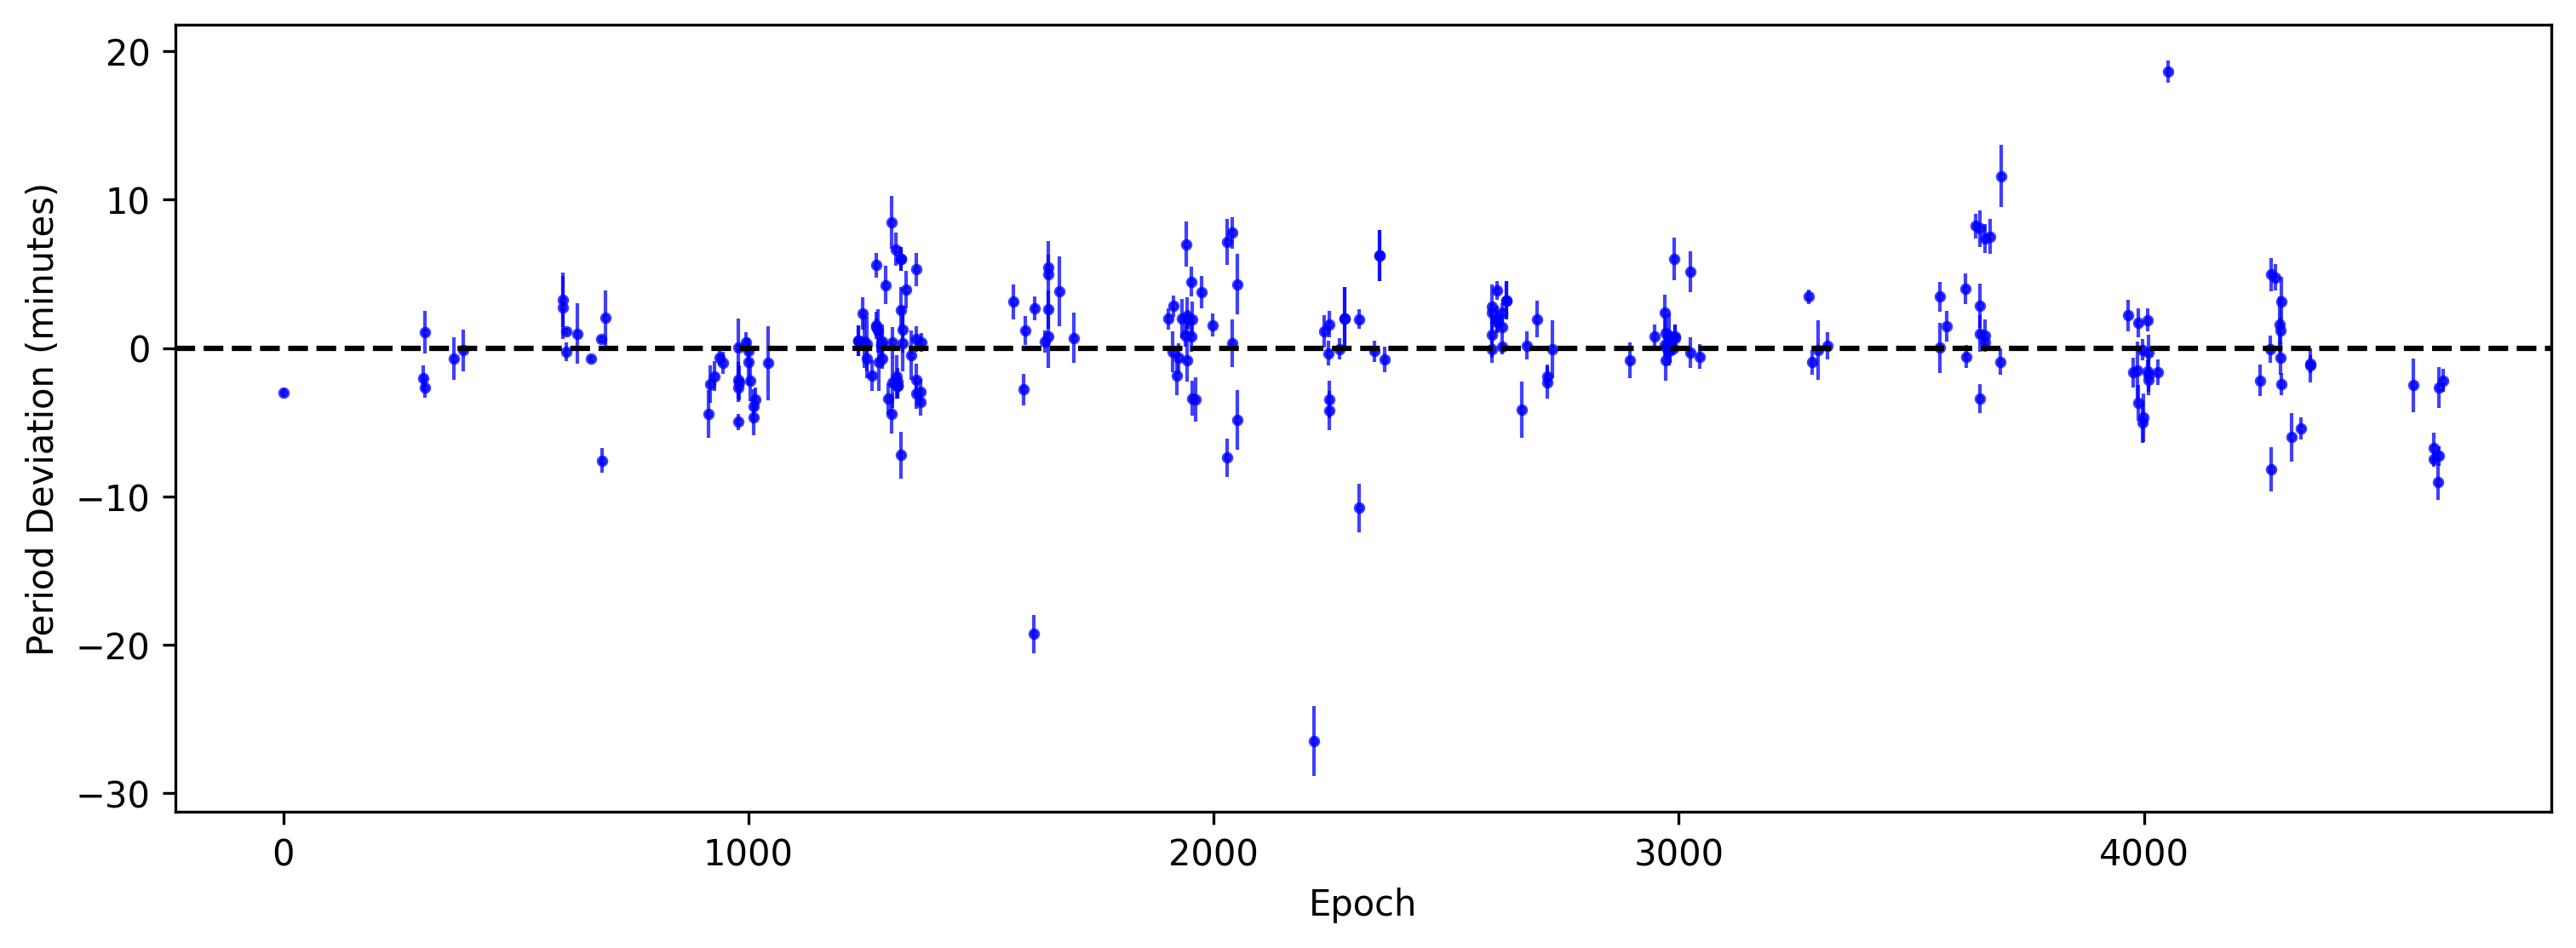

In [3]:
fig, ax = plt.subplots(figsize = (12, 4), dpi = 300)

ax.scatter(epochs, 1440. * (transit_times - (2454508.978941705 + (1.0914194874148295 * epochs))), s = 5, color = "blue", alpha = 0.75)
ax.errorbar(epochs, 1440. * (transit_times - (2454508.978941705 + (1.0914194874148295 * epochs))), yerr = 1440. * transit_time_errors, color = "blue", linestyle = "None", elinewidth = 1, alpha = 0.75)
ax.axhline(0, xmin = 0, xmax = 1, color = "black", ls = '--')
ax.set_xlabel("Epoch")
ax.set_ylabel("Period Deviation (minutes)")

Now, this data might look a *little* quadratic (indicating that Model 2 fits it best!) There's only one way to know for sure, though...

### Problem 1: Writing our Modeling Functions

We will now write the modeling functions for these three models (the first one has been done for you.) Please finish the following function where it is marked 'TODO'.

In [4]:
def model_1_expected_transit_times(params):
    '''
    Returns the expected times of transit given t0, P according to Model 1.
    '''
    
    t0, P = params
    return t0 + (epochs * P)



def model_2_expected_transit_times(params):
    '''
    Returns the expected times of transit given t0, P, dP/dE according to Model 2.
    '''
    
    t0, P, dPdE = params
    # TODO: Finish this function
    return t0 + (epochs * P) + (0.5 * dPdE * (epochs ** 2))



def model_3_expected_transit_times(params):
    '''
    Returns the expected times of transit given t0, P, e, w0, dwdE according to Model 3.
    '''
    
    t0, P, e, w0, dwdE = params
    # TODO: Finish this function
    Pa = P / (1. - (dwdE / (2 * np.pi)))
    w = w0 + (dwdE * epochs)
    return t0 + (P * epochs) - ((e * Pa / np.pi) * np.cos(w))

### Problem 2: Writing our Priors
Let's use the same priors as the original paper does. They are given in Table 2 of the paper, but they are given here as concrete values:

#### Model 1
| Parameter | Unit | Prior | Bounds |
| :-: | :-: | :-: | :-: |
| $t_0$ | BJD | Uniform | (2454508.48, 2454509.48) |
| $P$   | days | Uniform | (0.591, 1.591) |

#### Model 2
| Parameter | Unit | Prior | Bounds |
| :-: | :-: | :-: | :-: |
| $t_0$ | BJD | Uniform | (2454508.48, 2454509.48) |
| $P$   | days | Uniform | (0.591, 1.591) |
| $dP/dE$   | days/epoch | Uniform | (-1e-7, 1e-7) |

(Note that $dP/dE$ *can* be positive according to this prior! It would imply the orbital period is *increasing*, which can happen if dynamic effects are causing the planet to migrate outward.)

#### Model 3
*Note that these params are different than in the first two models!*

| Parameter | Unit | Prior | Mean | Standard Deviation | Bounds |
| :-: | :-: | :-: | :-: | :-: | :-: |
| $t_0$ | BJD | Uniform | -- | -- | (2454508.88, 2454509.08) |
| $P$   | days | Gaussian | 1.091 | 0.1 | (0.991, 1.191) |
| $e$   | -- | Log-Uniform | -- | -- | (1e-5, 1e-1) |
| $\omega_0$  | rad | Uniform | -- | -- | (0, 2π) |
| $d\omega/dE$  | rad/epoch | Log-Uniform | -- | -- | (1e-6, 1e-3) |

So, as a quick reminder for the log-likelihood of a uniform prior: if a parameter is within the lower and upper bounds of a uniform prior, then its likelihood is 0; otherwise, it's $-\infty$ (which you write as ``-np.inf``.)

The log-likelihood of a Gaussian distribution (also called a *normal distribution*) and a log-uniform distribution (also called a *reciprocal distribution* are given to you, though the bounds on the Gaussian distribution are not. Feel free to use them!

(Note that this means that the log-prior for Model 3 won't necessarily be 0 or $-\infty$! Non-uniform priors should return finite and negative values, indicating that we still believe they *can* occur while still being less likely to believe values with very negative priors.)

The prior for Model 1 has been done for you. Please finish the remaining functions where they are marked 'TODO'.

In [5]:
def log_likelihood_gaussian(value, mu, sigma):
    '''
    Returns the log-likelihood of a Gaussian distribution given the mean and standard deviation of the distribution.
    '''
    
    return (-0.5 * np.log(2 * np.pi * (sigma ** 2))) + (-0.5 * (1 / (sigma ** 2)) * ((value - mu) ** 2))
#     return (0) + (-0.5 * (1 / (sigma ** 2)) * ((value - mu) ** 2))




def log_likelihood_reciprocal(value, a, b):
    '''
    Returns the log-likelihood of a reciprocal distribution given the lower and upper limits a, b of the distribution.
    Note that this requires a < b, a > 0.
    '''
    
    if (value < a) or (value > b):
        return -np.inf
    
    prob = 1. / (value * (np.log(b) - np.log(a)))
    return np.log(prob)

In [6]:
def model_1_log_prior(params):
    '''
    Returns the prior log-likelihood of transit given t0, P according to Model 1.
    '''
    
    t0, P = params
    if (t0 < 2454508.48) or (t0 > 2454509.48):
        return -np.inf
    if (P < 0.591) or (P > 1.591):
        return -np.inf
    return 0



def model_2_log_prior(params):
    '''
    Returns the prior log-likelihood of transit given t0, P, dP/dE according to Model 2.
    '''
    
    t0, P, dPdE = params
    # TODO: Finish this function
    if (t0 < 2454508.48) or (t0 > 2454509.48):
        return -np.inf
    if (P < 0.591) or (P > 1.591):
        return -np.inf
    if (dPdE < -1e-7) or (dPdE > 1e-7):
        return -np.inf
    return 0



def model_3_log_prior(params):
    '''
    Returns the prior log-likelihood of transit given t0, P, e, w0, dwdE according to Model 3.
    '''
    
    t0, P, e, w0, dwdE = params
    # TODO: Finish this function
    if (t0 < 2454508.88) or (t0 > 2454509.08):
        return -np.inf
    if (P < 0.991) or (P > 1.191):
        return -np.inf
    if (w0 < 0.) or (w0 > (2 * np.pi)):
        return -np.inf
    return log_likelihood_gaussian(P, 1.091, 0.1) + log_likelihood_reciprocal(e, 1e-5, 1e-1) + log_likelihood_reciprocal(dwdE, 1e-6, 1e-3)

### Problem 3: Writing our Posterior Function

In the following cell, we will write our *posterior function* (reminder that our log likelihood is the posterior plus the prior!) We will use the same method of calculating our posterior likelihood as in our demo:

\begin{equation}
LL = -\frac{1}{2} \chi^2 = -\frac{1}{2} \sum_{n} \frac{(f_n - m_n)^2}{\sigma_n^2}
\end{equation}

The chi-squared function and our log-likelihood functions have been provided for you, as well as the log-posterior for Model 1. Please finish the remaining log-posterior functions in the spaces marked 'TODO'.

In [7]:
def chi2(expected_times):
    '''
    Returns the chi-squared value of our expected transit times.
    '''
    return np.sum(np.power((transit_times - expected_times) / transit_time_errors, 2))



def model_1_log_posterior(params):
    '''
    Returns the log-posterior of transit given t0, P according to Model 1.
    '''

    return -0.5 * chi2(model_1_expected_transit_times(params))



def model_2_log_posterior(params):
    '''
    Returns the log-posterior of transit given t0, P, dP/dE according to Model 2.
    '''
    
    # TODO: Finish this function
    return -0.5 * chi2(model_2_expected_transit_times(params))



def model_3_log_posterior(params):
    '''
    Returns the log-posterior of transit given t0, P, e, w0, dwdE according to Model 3.
    '''
    
    # TODO: Finish this function
    return -0.5 * chi2(model_3_expected_transit_times(params))





def model_1_log_likelihood(params):
    '''
    Returns the complete log-likelihood of transit given t0, P according to Model 1.
    '''
    return model_1_log_posterior(params) + model_1_log_prior(params)



def model_2_log_likelihood(params):
    '''
    Returns the complete log-likelihood of transit given t0, P, dP/dE according to Model 2.
    '''
    return model_2_log_posterior(params) + model_2_log_prior(params)



def model_3_log_likelihood(params):
    '''
    Returns the complete log-likelihood of transit given t0, P, e, w0, dwdE according to Model 3.
    '''
    return model_3_log_posterior(params) + model_3_log_prior(params)

### Problem 4: Plugging it Into ``emcee``

Now that we have our likelihood functions, we can go ahead and plug our likelihood functions into ``emcee``!

In the following cells, you are going to perform three different ``emcee`` fits: one for each of the three models. You may initialize any number of walkers and initialize your walkers at any points you choose.

You may also run your MCMC fit for as long as you choose, so long as you ensure that you are running your fit for at 50x the maximum autocorrelation time. (Bonus points if you create a loop that will check for this and stop your fit once this threshold is reached, but it's not necessary!)

The fit for Model 1 has been provided for you, though the aforementioned loop has not. Please finish the remaining 2 cells where TODO is marked.


#### Hints

Here are some tips to fix a few common errors and issues in this section.

• If you see that the autocorrelation time is ``nan``, make sure that all your walkers start within your uniform priors! If a walker begins well outside your priors, it might never make it into your priors, messing up the calculations for your autocorrelation time!

• All models take a little while to run, especially model 3! From my own testing, Model 1 took 4,000 steps to run, Model 2 took 6,000, and Model 3 took 190,000! Don't worry if they're not converging quickly, especially Model 3. Model 3 took 5 minutes or so to run on my Macbook Air, for reference, and more complex models you might use in your actual research can take hours or even *days* to run!

• If you're trying to get bonus points, and you're getting tired of ``emcee.get_autocorr_time()`` throwing errors and warnings all the time, try this code to give you the autocorrelation times without any errors or warnings:

> ``sampler.get_autocorr_time(tol = 0, quiet = True))``

• If you plot your chains for Model 3 (either through a plot of walker vs. step or a corner plot) and see that the walkers are pushing right up against the $e = 0.1$ prior boundary, that's okay! If this happens, it *can* indicate, that your priors might be too restrictive, but the paper indicates that previous observations have constrained the eccentricity to this value.

• Model 3 in particular has issues converging. The author of Hagey et al. (2022) even went so far as to write their own parameter sampling code specifically for this model because of this, and the values we should get from this fit are not the same as in that paper! So long as you keep that in mind, then, it's okay to get that result for this assignment. (It might be helpful to read through §4.0.3 of that paper, so you can see *why* they wrote their own MCMC code for this model!)

In [8]:
np.random.seed(1) # Just so we can replicate this
# TODO: In this cell, perform an MCMC fit for Model 1, defining the sampler as 'sampler_model_1'.

walker_positions = [2454508.98, 1.091] + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = walker_positions.shape

sampler_model_1 = emcee.EnsembleSampler(nwalkers, ndim, model_1_log_likelihood)
sampler_model_1.run_mcmc(walker_positions, 1000, progress=False);

numSteps = 1000
isConverged = False
while (not isConverged):
    sampler_model_1.run_mcmc(None, 1000, progress=False);
    numSteps += 1000
    
    tau = round(max(sampler_model_1.get_autocorr_time(tol = 0, quiet = True)))
    if (50 * tau < numSteps):
        isConverged = True
    print(f"Code has run for {numSteps} steps.")

print(f"Model 1 finished! It took {numSteps} steps.")
print(f"Tau: {tau}")

flat_samples = sampler_model_1.get_chain(discard = 5 * tau, thin = tau, flat = True)
params_1 = []
labels = ["t0", "P"]
for i in range(2):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]} {' ' * (5 - len(labels[i]))} : {mcmc[1]:.6f} {' ' * (10 - len((str)(round(mcmc[1]))))}  - {q[0]:.6f} {' ' * (10 - len((str)(round(q[0]))))} + {q[1]:.6f}")
    params_1.append(mcmc[1])

Code has run for 2000 steps.
Code has run for 3000 steps.
Code has run for 4000 steps.
Model 1 finished! It took 4000 steps.
Tau: 63
t0     : 2454508.978801      - 0.000064           + 0.000065
P      : 1.091420            - 0.000000           + 0.000000


In [9]:
np.random.seed(1) # Just so we can replicate this
# TODO: In this cell, perform an MCMC fit for Model 2, defining the sampler as 'sampler_model_2'.

walker_positions = [2454508.98, 1.091, 0.] + 1e-4 * ([1., 1., 1e-5] * np.random.randn(32, 3))
nwalkers, ndim = walker_positions.shape

sampler_model_2 = emcee.EnsembleSampler(nwalkers, ndim, model_2_log_likelihood)
sampler_model_2.run_mcmc(walker_positions, 1000, progress=False);

numSteps = 1000
isConverged = False
while (not isConverged):
    sampler_model_2.run_mcmc(None, 1000, progress=False);
    numSteps += 1000
    
    tau = round(np.amax(sampler_model_2.get_autocorr_time(tol = 0, quiet = True)))
    if (50 * tau < numSteps):
        isConverged = True
    print(f"Code has run for {numSteps} steps.")

print(f"Model 2 finished! It took {numSteps} steps.")
print(f"Tau: {tau}")

flat_samples = sampler_model_2.get_chain(discard = 5 * tau, thin = tau, flat = True)
labels = ["t0", "P", "dP/dE"]
params_2 = []
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]} {' ' * (10 - len(labels[i]))} : {mcmc[1]:.10f} {' ' * (20 - len((str)(round(mcmc[1]))))}  - {q[0]:.10f} {' ' * (20 - len((str)(round(q[0]))))} + {q[1]:.10f}")
    params_2.append(mcmc[1])

Code has run for 2000 steps.
Code has run for 3000 steps.
Code has run for 4000 steps.
Code has run for 5000 steps.
Code has run for 6000 steps.
Model 2 finished! It took 6000 steps.
Tau: 99
t0          : 2454508.9773028158                - 0.0001010192                     + 0.0001020627
P           : 1.0914216838                      - 0.0000001171                     + 0.0000001108
dP/dE       : -0.0000000009                      - 0.0000000000                     + 0.0000000000


In [10]:
np.random.seed(1) # Just so we can replicate this
# TODO: In this cell, perform an MCMC fit for Model 2, defining the sampler as 'sampler_model_2'.

walker_positions = [2454508.97, 1.091, 0.03, np.pi, 1e-4] + 1e-6 * ([1., 1., 1e-6, 1., 1e-7] * np.random.randn(32, 5))
nwalkers, ndim = walker_positions.shape

sampler_model_3 = emcee.EnsembleSampler(nwalkers, ndim, model_3_log_likelihood)
sampler_model_3.run_mcmc(walker_positions, 5000, progress=False);

numSteps = 5000
isConverged = False
while (not isConverged):
    sampler_model_3.run_mcmc(None, 5000, progress=False);
    numSteps += 5000
    
    tau = round(np.amax(sampler_model_3.get_autocorr_time(tol = 0, quiet = True)))
    if (50 * tau < numSteps):
        isConverged = True
    print(f"Code has run for {numSteps} steps.   # autocorr. times ran: {round(numSteps / tau, 1)}")

print(f"Model 3 finished! It took {numSteps} steps.")
print(f"Tau: {tau}")

flat_samples = sampler_model_3.get_chain(discard = 5 * tau, thin = tau, flat = True)
labels = ["t0", "P", "e", "w0", "dw/dE"]
params_3 = []
for i in range(5):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]} {' ' * (10 - len(labels[i]))} : {mcmc[1]:.10f} {' ' * (20 - len((str)(round(mcmc[1]))))}  - {q[0]:.10f} {' ' * (20 - len((str)(round(q[0]))))} + {q[1]:.10f}")
    params_3.append(mcmc[1])

Code has run for 10000 steps.   # autocorr. times ran: 9.6
Code has run for 15000 steps.   # autocorr. times ran: 11.0
Code has run for 20000 steps.   # autocorr. times ran: 11.4
Code has run for 25000 steps.   # autocorr. times ran: 12.5
Code has run for 30000 steps.   # autocorr. times ran: 14.0
Code has run for 35000 steps.   # autocorr. times ran: 16.1
Code has run for 40000 steps.   # autocorr. times ran: 18.0
Code has run for 45000 steps.   # autocorr. times ran: 19.7
Code has run for 50000 steps.   # autocorr. times ran: 20.7
Code has run for 55000 steps.   # autocorr. times ran: 22.7
Code has run for 60000 steps.   # autocorr. times ran: 24.2
Code has run for 65000 steps.   # autocorr. times ran: 25.1
Code has run for 70000 steps.   # autocorr. times ran: 25.8
Code has run for 75000 steps.   # autocorr. times ran: 26.7
Code has run for 80000 steps.   # autocorr. times ran: 28.3
Code has run for 85000 steps.   # autocorr. times ran: 29.5
Code has run for 90000 steps.   # autocor

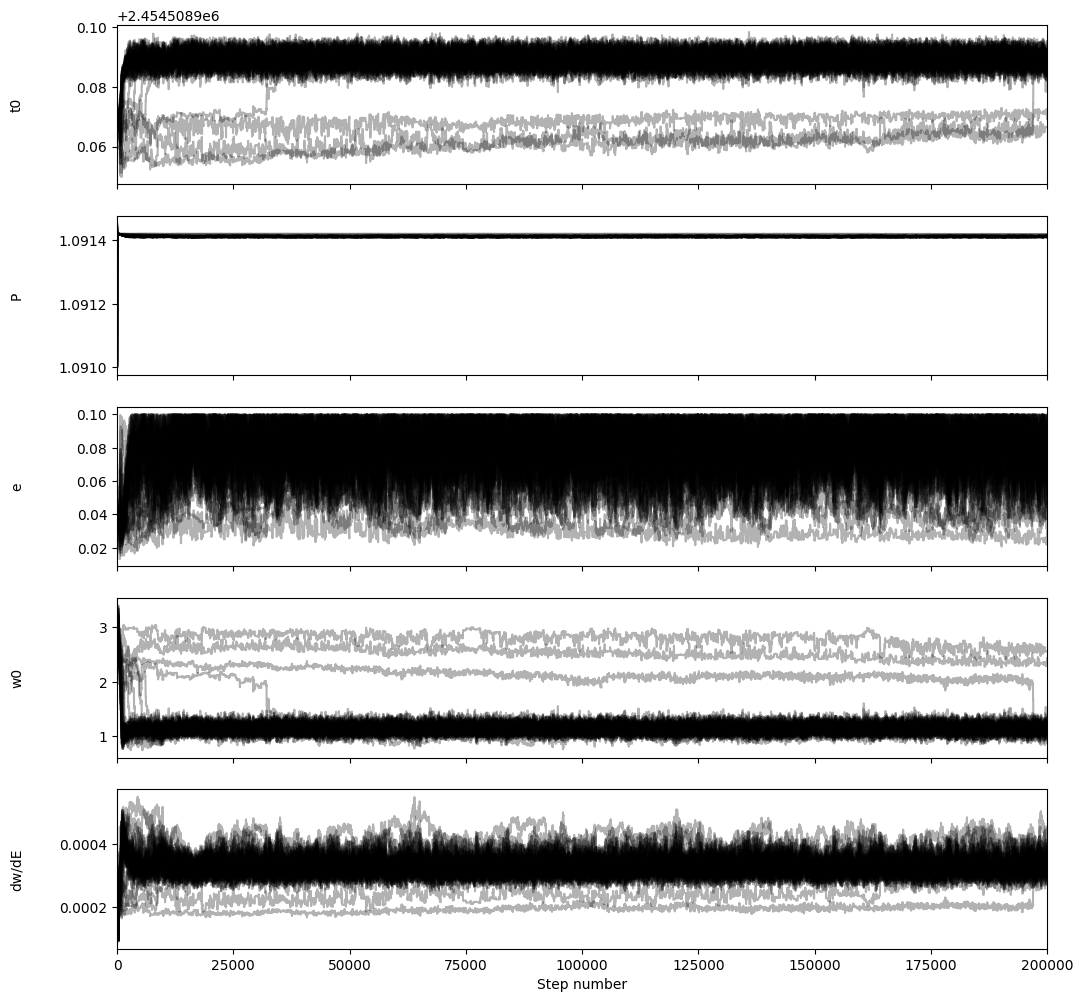

In [11]:
# Use this cell for checking diagnostics and making plots if you'd like!

# This is a plot for model 3.
labels = ["t0", "P", "e", "w0", "dw/dE"]
fig, axes = plt.subplots(5, figsize=(12, 12), sharex = True)
samples = sampler_model_3.get_chain()
for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("Step number");

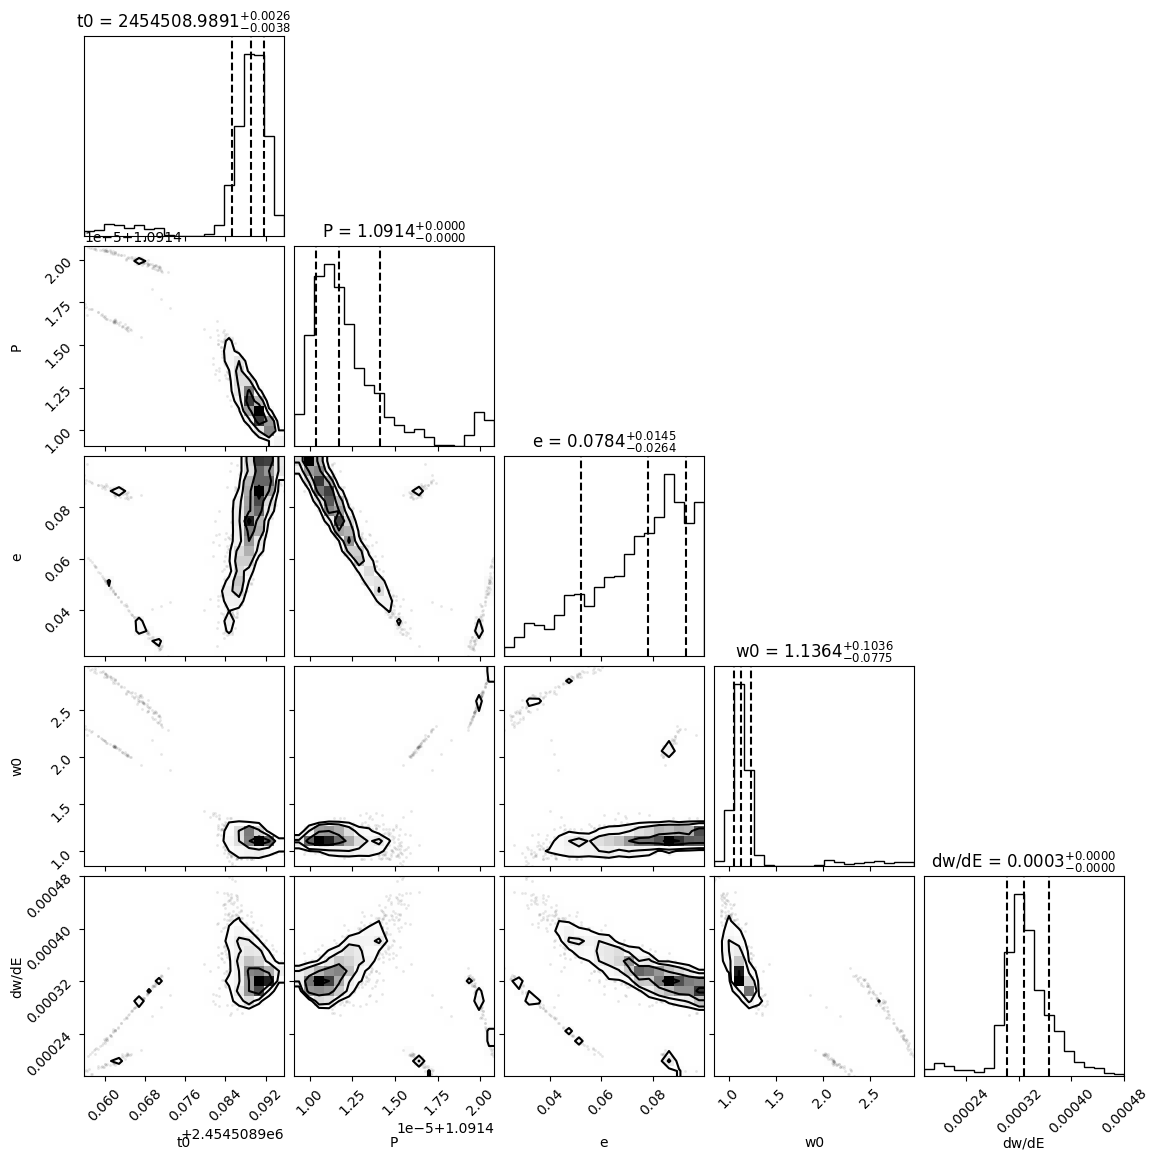

In [12]:
fig = corner.corner(flat_samples, labels = labels,
                    quantiles = [0.16, 0.5, 0.84], show_titles = True, title_fmt = '.4f');

The following code will plot the results of your models.

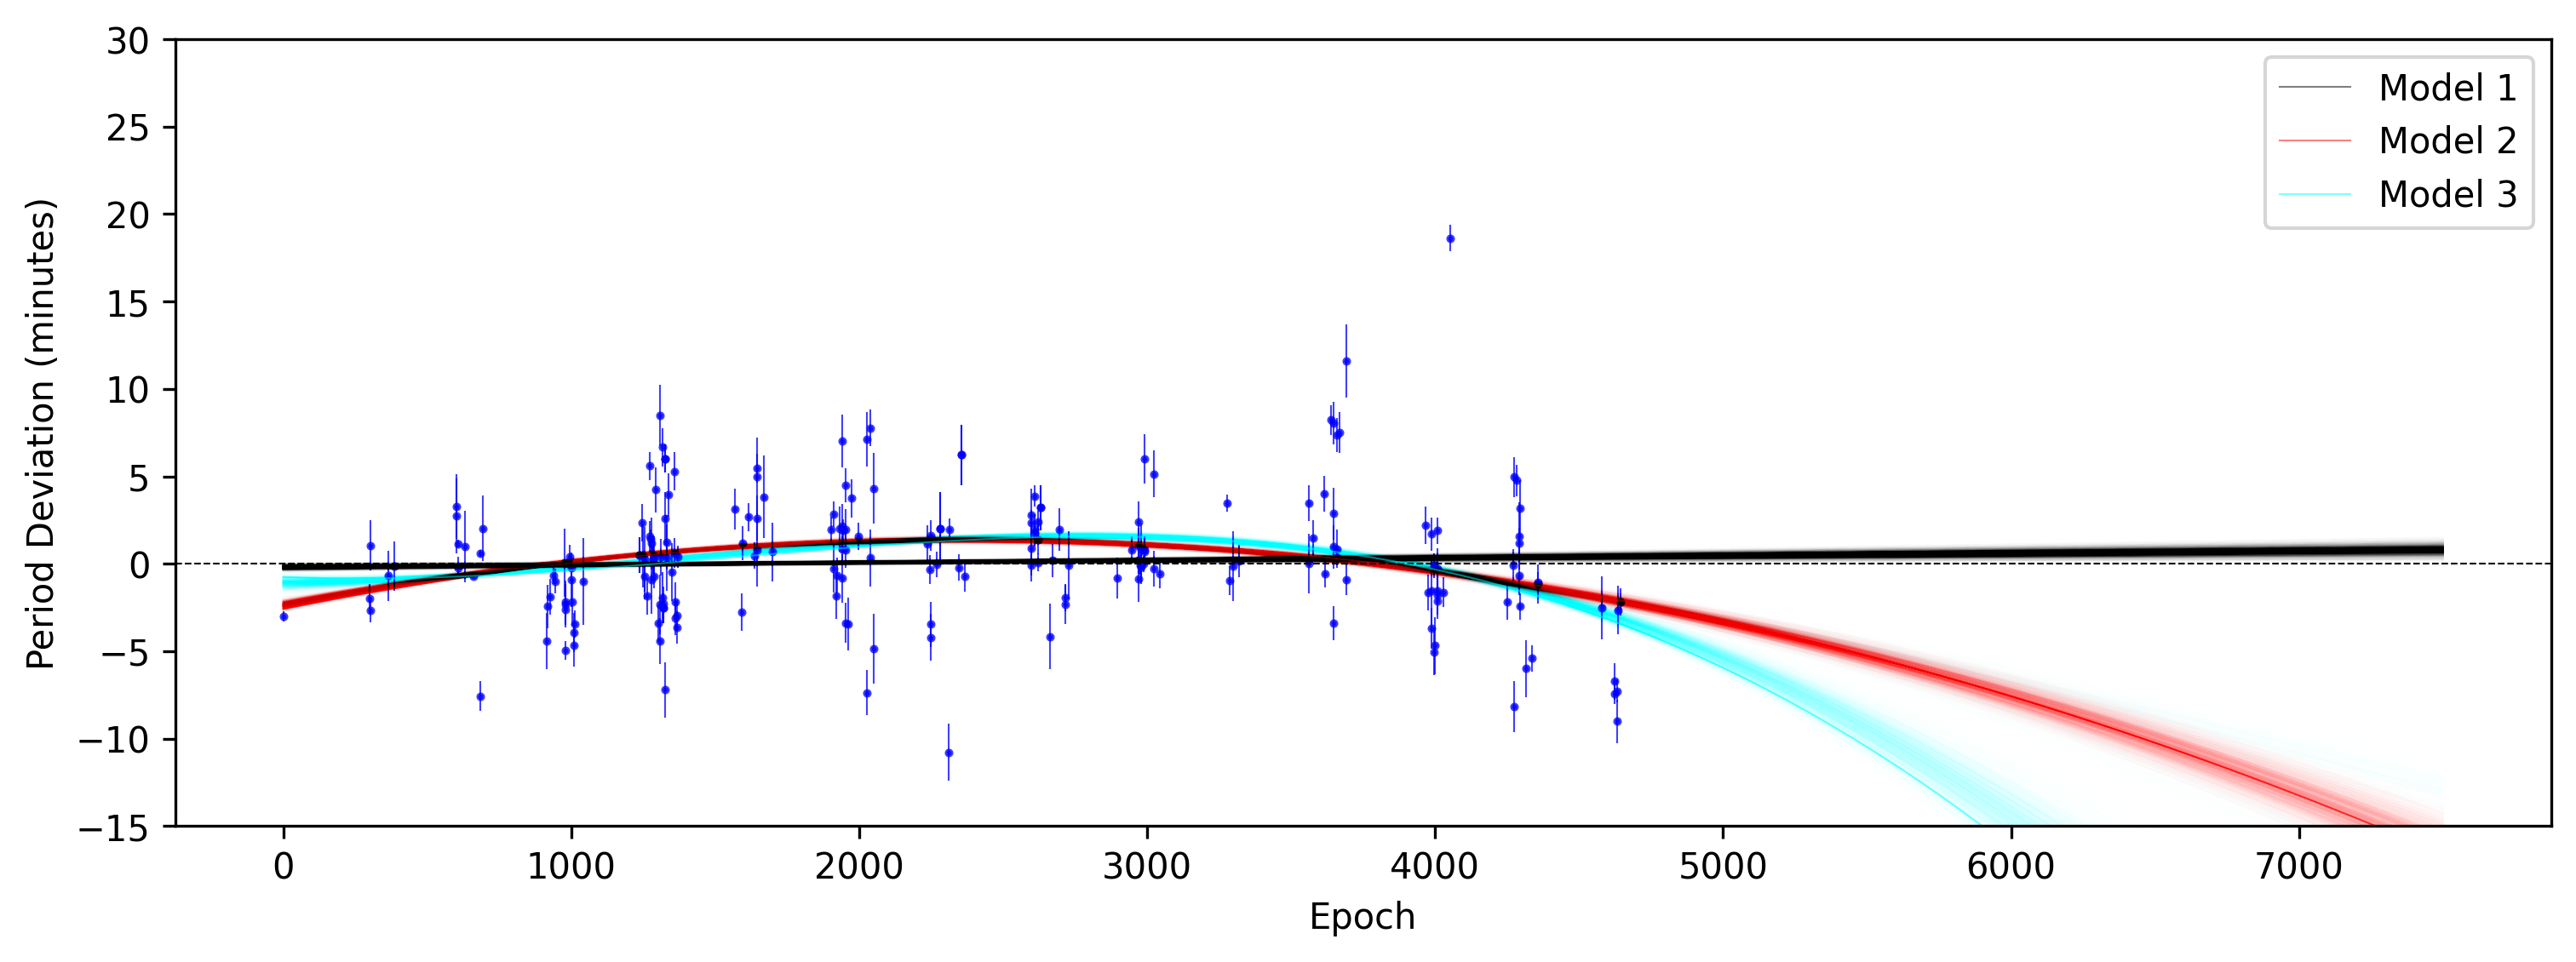

In [13]:
fig, ax = plt.subplots(figsize = (12, 4), dpi = 300)

epochs = np.linspace(0, 7500, num = 100)
linmod = (2454508.978941705 + (1.0914194874148295 * epochs))
linmodold = (2454508.978941705 + (1.0914194874148295 * data["Epoch"].values))
ttvs = 1440. * (transit_times - linmodold)
ax.scatter(data["Epoch"].values, ttvs, color = "blue", alpha = 0.75, s = 2)
ax.errorbar(data["Epoch"].values, ttvs, yerr = 1440. * transit_time_errors, color = "blue", linestyle = "None", elinewidth = 0.5, alpha = 0.75)
ax.axhline(0, xmin = 0, xmax = 1, color = "black", ls = '--', lw = 0.5)
ax.set_xlabel("Epoch")
ax.set_ylabel("Period Deviation (minutes)")
ax.set_ylim(-15, 30)

max_autocorr_time_1 = round(max(sampler_model_1.get_autocorr_time(quiet = True)))
flat_samples_1 = sampler_model_1.get_chain(discard = 5 * max_autocorr_time_1, thin = max_autocorr_time_1, flat = True)

max_autocorr_time_2 = round(max(sampler_model_2.get_autocorr_time(quiet = True)))
flat_samples_2 = sampler_model_2.get_chain(discard = 5 * max_autocorr_time_2, thin = max_autocorr_time_2, flat = True)

max_autocorr_time_3 = round(max(sampler_model_3.get_autocorr_time(quiet = True)))
flat_samples_3 = sampler_model_3.get_chain(discard = 5 * max_autocorr_time_3, thin = max_autocorr_time_3, flat = True)

for i, param_set_1 in enumerate(flat_samples_1):
    if (i == 0):
        ax.plot(epochs, 1440. * (model_1_expected_transit_times(param_set_1) - linmod), color = "black", alpha = 0.5, lw = 0.5, label = "Model 1")
    else:
        ax.plot(epochs, 1440. * (model_1_expected_transit_times(param_set_1) - linmod), color = "black", alpha = 0.005, lw = 0.5)
for i, param_set_2 in enumerate(flat_samples_2):
    if (i == 0):
        ax.plot(epochs, 1440. * (model_2_expected_transit_times(param_set_2) - linmod), color = "red", alpha = 0.5, lw = 0.5, label = "Model 2")
    else:
        ax.plot(epochs, 1440. * (model_2_expected_transit_times(param_set_2) - linmod), color = "red", alpha = 0.005, lw = 0.5)
for i, param_set_3 in enumerate(flat_samples_3):
    if (i == 0):
        ax.plot(epochs, 1440. * (model_3_expected_transit_times(param_set_3) - linmod), color = "cyan", alpha = 0.5, lw = 0.5, label = "Model 3")
    else:
        ax.plot(epochs, 1440. * (model_3_expected_transit_times(param_set_3) - linmod), color = "cyan", alpha = 0.005, lw = 0.5)
ax.legend();

linmod = (2454508.978941705 + (1.0914194874148295 * data["Epoch"].values))
mask = abs(1440. * (data["Transit Time"].values - linmod)) < 10.
data = data.iloc[mask]

epochs = data["Epoch"].values
transit_times = data["Transit Time"].values
transit_time_errors = data["Error"].values

### Problem 5: Arriving at our Conclusions

Now that we have performed our MCMC fit, we need to come to our conclusions.

If our models were of equal complexity, then we would simply say that the one with the best log-likelihood is our best model. However, Model 2 has an extra parameter vary, meaning that the added complexity of the model might fit our data better without actually telling us much. (Consider that if $dP/dE$ were 0, then Model 2 would be the same as Model 1, so it can always do at least as well as Model 1 does!) Model 3 has the same issue, except with *five* parameters!

To get a final comparison of our three models, we will use what's called the model *Bayesian Information Criterion*:

\begin{equation}
\textrm{BIC} = \chi^2 + k \log n
\end{equation}

where $k$ is the number of parameters of that model (2 for Model 1, 3 for Model 2, 5 for Model 3) and $n$ is the number of data points we have (213). Essentially, it holds more complex models to a higher standard, insisting that they need to fit our data significantly better for us to believe that they are the true model over a simpler one.

The paper uses the following guide to compare two models below:

> With this in mind, the evidence strongly supports the model with the lower BIC value over the one with the larger value when $\Delta \textrm{BIC} > 10$. For $5 < \Delta \textrm{BIC} < 10$, the evidence supports the model with the lower BIC value, and if $\Delta \textrm{BIC} < 5$, while the lower BIC model is favored, the evidence in support of that distinction is weak.

In the cell below, calculate the BIC of the three models using the median parameters your three models spit out. Which one has the lowest BIC? What does the difference between the BICs imply about the evidence in support of this model over the other ones?

In [14]:
# Calculate BIC here!
BIC_model_1 = round((-2 * model_1_log_posterior(params_1)) + (2 * np.log(213)))
BIC_model_2 = round((-2 * model_2_log_posterior(params_2)) + (3 * np.log(213)))
BIC_model_3 = round((-2 * model_3_log_posterior(params_3)) + (5 * np.log(213)))
print(f"BIC for Model 1: {BIC_model_1}, BIC for Model 2: {BIC_model_2}, BIC for Model 3: {BIC_model_3}")
print(f"Since the difference between the two models is {BIC_model_3 - BIC_model_2} > 10, the data suggests that Model 2 is the best model, providing evidence for orbital decay of WASP-12 b.")

BIC for Model 1: 2364, BIC for Model 2: 1933, BIC for Model 3: 2010
Since the difference between the two models is 77 > 10, the data suggests that Model 2 is the best model, providing evidence for orbital decay of WASP-12 b.
